In [5]:
import pandas as pd
import sys; sys.path.insert(0, '..')
from stattest import Analysis
from clustering import ClusteringPipe

df = pd.read_csv('data_processed.csv').sample(10000)
race, gender = pd.Categorical(df.race),  pd.Categorical(df.gender)
y = pd.DataFrame({'race':race.codes, 'gender':gender.codes})
x_raw = df.drop(['encounter_id','patient_nbr', 'race', 'gender'], axis=1)

data = ClusteringPipe(x_raw, y)

## K-Means

### outlires removal

In [6]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires(p) \
                    .reduce('umap', n_components=30) \
                    .cluster('kmeans', n_clusters=7, random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['lof', 'non']})

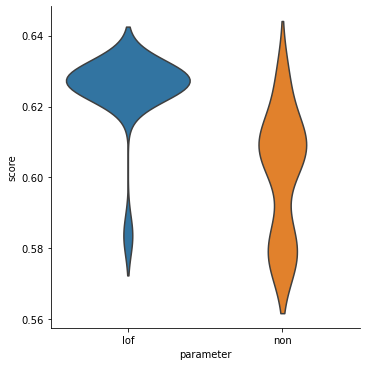

In [8]:
results.plot()

In [9]:
results.mean()

lof    0.624451
non    0.601215
dtype: float64

In [10]:
results.annova()

(38.94353792399219, 5.452053192421824e-08)

### dimension reduction method

In [11]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce(p, n_components=5, random_state=i) \
                    .cluster('kmeans', n_clusters=7, random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['pca', 'umap']})

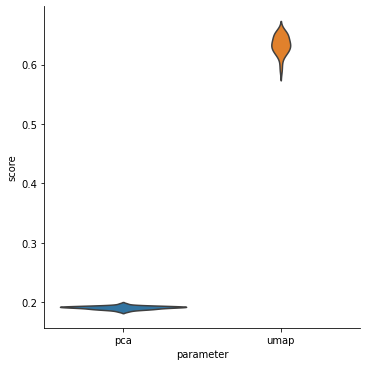

In [12]:
results.plot()

### number of clusters

detect potentially good k values with the elbow mehtod:

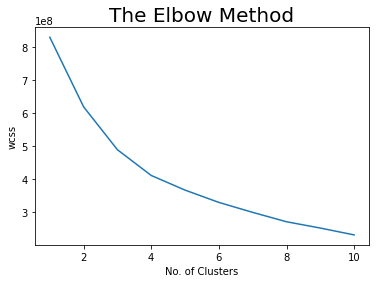

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x_raw)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

now we will test which one is the best using the full process

In [14]:
results = Analysis({k:[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce('umap', n_components=5) \
                    .cluster('kmeans', n_clusters=k, random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for k in [4,5,6,7]})

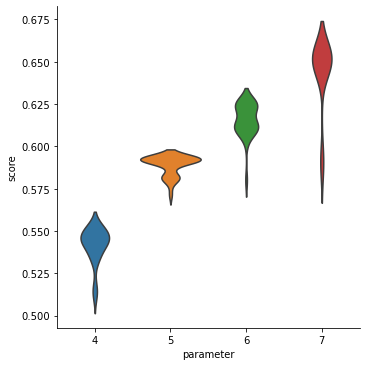

In [15]:
results.plot()

In [16]:
results.mean()

4    0.541579
5    0.589113
6    0.615789
7    0.643604
dtype: float64

In [17]:
results.annova()

(328.31304015984057, 1.6963230425554174e-56)

In [18]:
results.scheffe()

,4,5,6,7
4,1.000000e+00,7.270203e-25,4.915879e-41,1.258640e-54
5,7.270203e-25,1.000000e+00,8.642691e-11,2.180955e-29
6,4.915879e-41,8.642691e-11,1.000000e+00,1.565022e-11
7,1.258640e-54,2.180955e-29,1.565022e-11,1.000000e+00


### visualize cluster

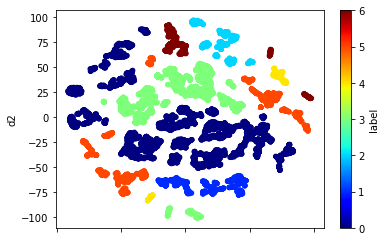

In [19]:
data.normalize('std') \
    .remove_outlires('lof') \
    .reduce('umap', n_components=5) \
    .cluster('kmeans', n_clusters=7) \
    .visualize('tsne')

### corelationg with target class

In [21]:
data.normalize('std') \
    .reduce('umap', n_components=5) \
    .cluster('kmeans', n_clusters=2) \
    .score('v', label='gender')

0.00018353884931636915

In [22]:
data.normalize('std') \
    .reduce('umap', n_components=5) \
    .cluster('kmeans', n_clusters=2) \
    .score('v', label='race')

0.0007210316914007073

## GMM

### outlires removal

In [23]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires(p) \
                    .reduce('umap', n_components=30) \
                    .cluster('gmm', n_components=6, random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['lof', 'non']})

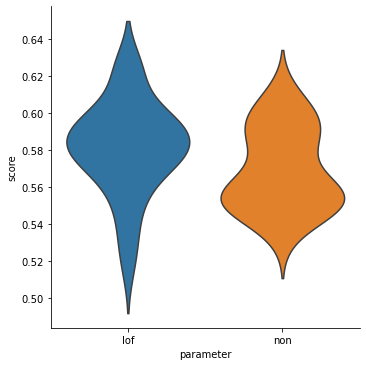

In [24]:
results.plot()

In [25]:
results.mean()

lof    0.581419
non    0.569471
dtype: float64

In [26]:
results.annova()

(3.820827908464907, 0.0554449423266999)

### Dimension Reduction Method

In [27]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .reduce(p, n_components=30, random_state=i) \
                    .cluster('gmm', n_components=6, random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['pca', 'umap', 'non']})

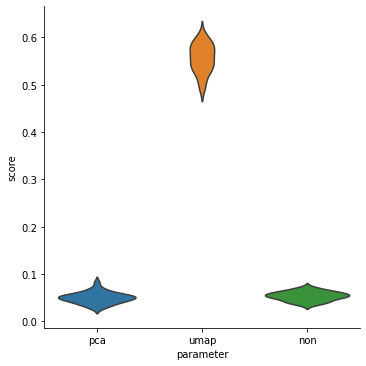

In [28]:
results.plot()

### Number of dimensions

In [29]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .reduce('umap', n_components=p, random_state=i) \
                    .cluster('gmm', n_components=6, random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in [5,10,20,30]})

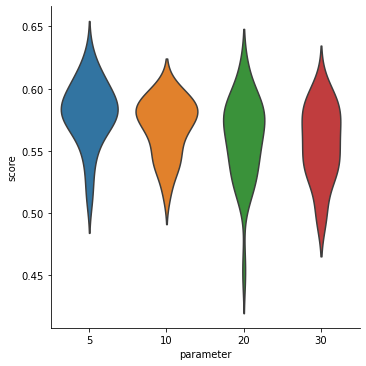

In [30]:
results.plot()

In [31]:
results.mean()

5     0.580153
10    0.569209
20    0.560074
30    0.555902
dtype: float64

In [32]:
results.annova()

(4.336842518585234, 0.0061778541576461244)

In [33]:
results.scheffe()

,5,10,20,30
5,1.000000,0.525727,0.061587,0.014292
10,0.525727,1.000000,0.668583,0.349734
20,0.061587,0.668583,1.000000,0.954863
30,0.014292,0.349734,0.954863,1.000000


### Coveriance Type

In [34]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .reduce('umap', n_components=5) \
                    .cluster('gmm', n_components=6, covariance_type=p, random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['spherical', 'tied', 'diag', 'full']
})

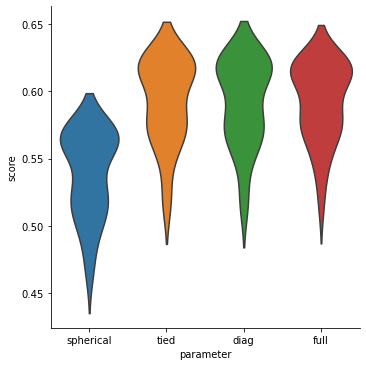

In [35]:
results.plot()

In [36]:
results.mean()

spherical    0.538666
tied         0.592068
diag         0.591246
full         0.591829
dtype: float64

In [37]:
results.annova()

(22.06523326099299, 2.2427049007765006e-11)

In [38]:
results.scheffe()

,spherical,tied,diag,full
spherical,1.000000e+00,2.857432e-08,4.638498e-08,3.290736e-08
tied,2.857432e-08,1.000000e+00,9.997091e-01,9.999928e-01
diag,4.638498e-08,9.997091e-01,1.000000e+00,9.998960e-01
full,3.290736e-08,9.999928e-01,9.998960e-01,1.000000e+00


### number of clusters

detect potentially good k values with the elbow mehtod:

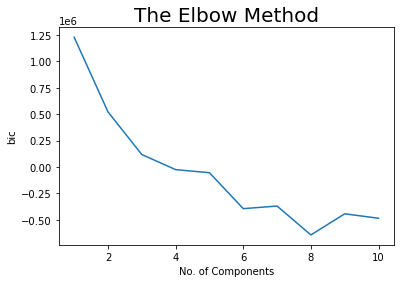

In [39]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

bic = []
for i in range(1, 11):
    gmm = GaussianMixture(n_components = i)
    gmm.fit(x_raw)
    bic.append(gmm.bic(x_raw))
    
plt.plot(range(1, 11), bic)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Components')
plt.ylabel('bic')
plt.show()

now we will test which one is the best using the full process

In [40]:
results = Analysis({k:[ \
                data.normalize('std') \
                    .reduce('umap', n_components=30) \
                    .cluster('gmm', n_components=k, random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for k in [3,4,5,6,7,8]})

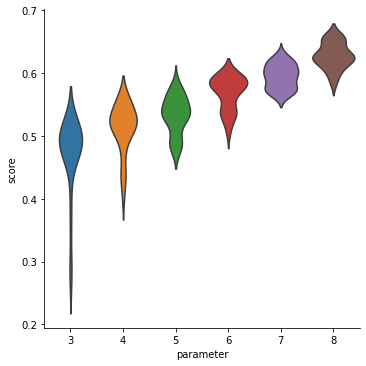

In [41]:
results.plot()

In [42]:
results.mean()

3    0.472539
4    0.513679
5    0.533438
6    0.568922
7    0.594945
8    0.628350
dtype: float64

In [43]:
results.annova()

(77.29994046285792, 2.2795360918523882e-42)

In [44]:
results.scheffe()

,3,4,5,6,7,8
3,1.000000e+00,1.624209e-03,1.493194e-07,2.963687e-17,3.366514e-25,2.006185e-35
4,1.624209e-03,1.000000e+00,4.577640e-01,2.927410e-06,7.263201e-13,8.171372e-23
5,1.493194e-07,4.577640e-01,1.000000e+00,1.207788e-02,1.070534e-07,8.121797e-17
6,2.963687e-17,2.927410e-06,1.207788e-02,1.000000e+00,1.552233e-01,3.306197e-07
7,3.366514e-25,7.263201e-13,1.070534e-07,1.552233e-01,1.000000e+00,2.315171e-02
8,2.006185e-35,8.171372e-23,8.121797e-17,3.306197e-07,2.315171e-02,1.000000e+00


### Cluster visualisation 

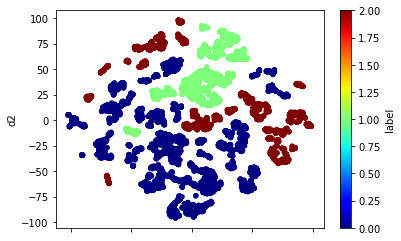

In [45]:
data.normalize('std') \
    .reduce('umap', n_components=5) \
    .cluster('gmm', n_components=3) \
    .visualize('tsne')

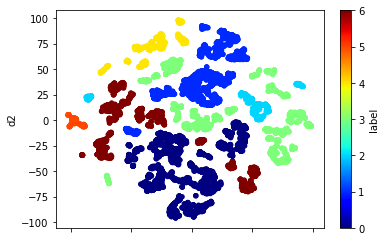

In [46]:
data.normalize('std') \
    .reduce('umap', n_components=5) \
    .cluster('gmm', n_components=7) \
    .visualize('tsne')

### corelationg with target class

In [47]:
data.normalize('std') \
    .reduce('umap', n_components=5) \
    .cluster('gmm', n_components=2) \
    .score('v', label='gender')

6.161621174997805e-07

In [48]:
data.normalize('std') \
    .reduce('umap', n_components=5) \
    .cluster('gmm', n_components=4) \
    .score('v', label='race')

0.0027659959821800307

## Louvaine

### outlires removal

In [49]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires(p) \
                    .reduce('umap', n_components=5, random_state=i) \
                    .cluster('louvain', random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['lof', 'non']})

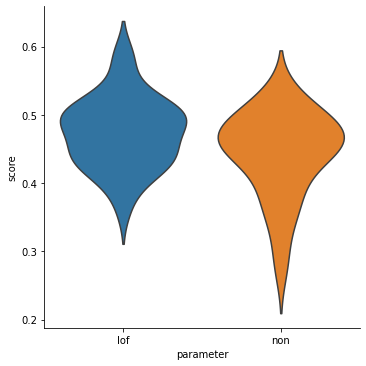

In [50]:
results.plot()

In [51]:
results.mean()

lof    0.474467
non    0.442619
dtype: float64

In [52]:
results.annova()

(4.631927210961252, 0.035556236415039355)

### Dimension Reduction Method

In [53]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce(p, n_components=10, random_state=i) \
                    .cluster('louvain') \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['pca', 'umap', 'non']})

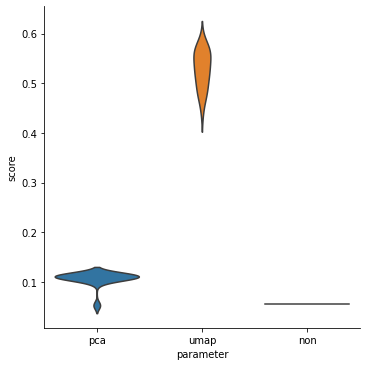

In [54]:
results.plot()

### Number of dimensions

In [55]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce('umap', n_components=p, random_state=i) \
                    .cluster('louvain', random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in [5,10,15, 20]})

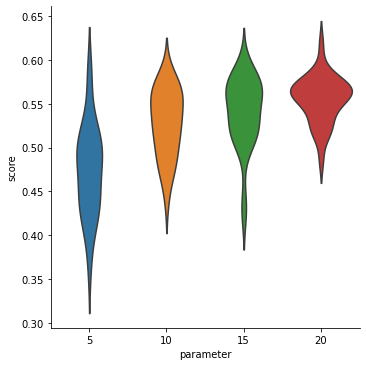

In [56]:
results.plot()

In [57]:
results.mean()

5     0.474467
10    0.527698
15    0.540183
20    0.555377
dtype: float64

In [58]:
results.annova()

(23.297178199818852, 7.112710078123049e-12)

In [59]:
results.scheffe()

,5,10,15,20
5,1.000000e+00,0.000024,1.222447e-07,9.604938e-11
10,2.373459e-05,1.000000,6.905550e-01,7.108753e-02
15,1.222447e-07,0.690555,1.000000e+00,5.394789e-01
20,9.604938e-11,0.071088,5.394789e-01,1.000000e+00


### Modularity Type

In [60]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce('umap', n_components=15, random_state=i) \
                    .cluster('louvain', modularity=p, random_state=i) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['dugue', 'newman', 'potts']
})

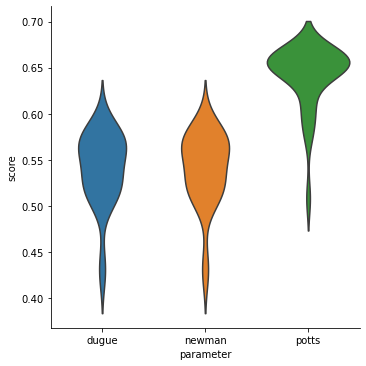

In [61]:
results.plot()

In [62]:
results.mean()

dugue     0.540183
newman    0.540183
potts     0.641043
dtype: float64

In [63]:
results.annova()

(70.0363000400005, 7.514872387827154e-19)

### Cluster visualisation 

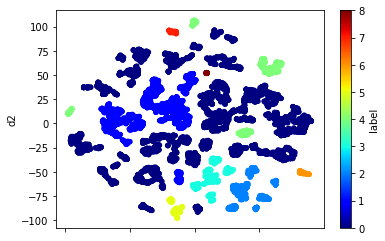

In [129]:
data.normalize('std') \
    .remove_outlires('lof') \
    .reduce('umap', n_components=15) \
    .cluster('louvain', modularity='potts') \
    .visualize('tsne')

### corelationg with target class

In [65]:
data.normalize('std') \
    .reduce('umap', n_components=15) \
    .cluster('louvain', modularity='newman') \
    .score('v', label='gender')

0.0004274975037163659

In [66]:
data.normalize('std') \
    .reduce('umap', n_components=15) \
    .cluster('louvain', modularity='newman') \
    .score('v', label='race')

0.004619602826804302

## Prim

### outlires removal

In [67]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires(p) \
                    .reduce('umap', n_components=15, random_state=i) \
                    .cluster('prim', cutoff_scale=0.8) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['lof', 'non']})

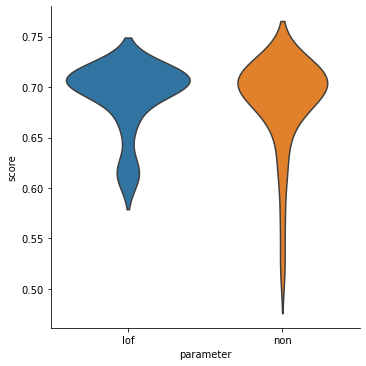

In [68]:
results.plot()

In [69]:
results.mean()

lof    0.690806
non    0.684804
dtype: float64

In [70]:
results.annova()

(0.3420280266576319, 0.5609292359291937)

### Dimension Reduction Method

In [71]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce(p, n_components=40, random_state=i) \
                    .cluster('prim', cutoff_scale=2) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['pca', 'umap', 'non']})

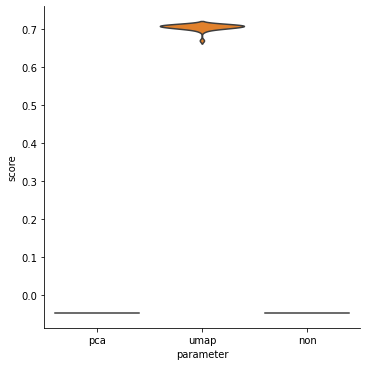

In [72]:
results.plot()

### Number of dimensions

In [73]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce('umap', n_components=p, random_state=i) \
                    .cluster('prim', cutoff_scale=2) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in [5, 10, 15, 20, 30, 40]})

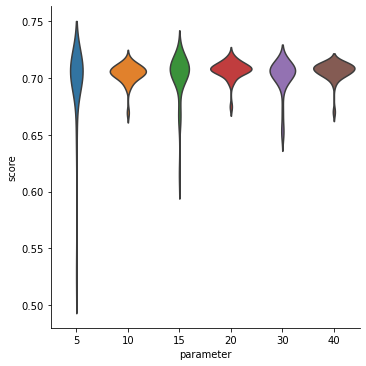

In [74]:
results.plot()

In [75]:
results.mean()

5     0.696853
10    0.703785
15    0.700854
20    0.706977
30    0.701093
40    0.706065
dtype: float64

In [76]:
results.annova()

(1.217169540388136, 0.3030129307538943)

In [77]:
results.scheffe()

,5,10,15,20,30,40
5,1.000000,0.839742,0.983430,0.496027,0.978532,0.603130
10,0.839742,1.000000,0.996083,0.994144,0.997382,0.998823
15,0.983430,0.996083,1.000000,0.899446,1.000000,0.947622
20,0.496027,0.994144,0.899446,1.000000,0.913966,0.999987
30,0.978532,0.997382,1.000000,0.913966,1.000000,0.957000
40,0.603130,0.998823,0.947622,0.999987,0.957000,1.000000


### Cutoff Scale

In [78]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce('umap', n_components=40, random_state=i) \
                    .cluster('prim', cutoff_scale=p) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in [0.6, 0.7, 0.8, 0.9]
})

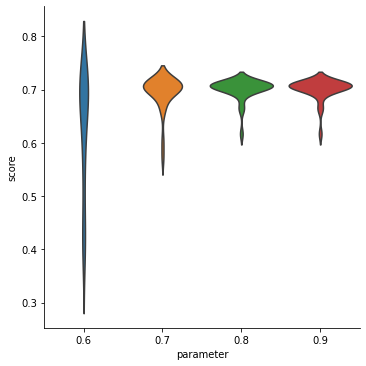

In [79]:
results.plot()

In [80]:
results.mean()

0.6    0.622989
0.7    0.694431
0.8    0.700751
0.9    0.700751
dtype: float64

In [81]:
results.annova()

(11.648365958083566, 9.9551710379979e-07)

### Cluster visualisation 

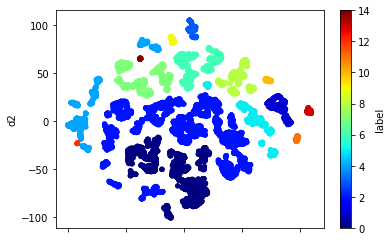

In [82]:
data.normalize('std') \
    .remove_outlires('lof') \
    .reduce('umap', n_components=40) \
    .cluster('prim', cutoff_scale=0.8) \
    .visualize('tsne')

### corelationg with target class

In [83]:
data.normalize('std') \
    .reduce('umap', n_components=40) \
    .cluster('prim', cutoff_scale=0.8) \
    .score('v', label='gender')

0.0007880935299956932

In [84]:
data.normalize('std') \
    .reduce('umap', n_components=40) \
    .cluster('prim', cutoff_scale=0.8) \
    .score('v', label='race')

0.006376661145781906

## DBSCAN

### outlires removal

In [85]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .remove_outlires(p) \
                    .reduce('umap', n_components=40, random_state=i) \
                    .cluster('dbscan', eps=0.5, min_samples=5) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in ['lof', 'non']})

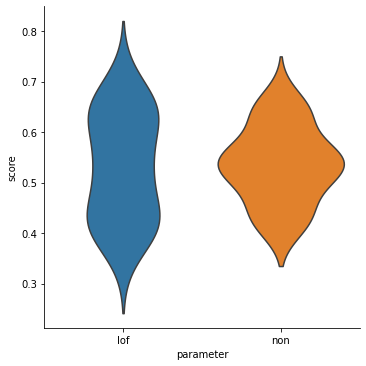

In [86]:
results.plot()

In [87]:
results.mean()

lof    0.530295
non    0.535406
dtype: float64

In [88]:
results.annova()

(0.04632642508676193, 0.8303385920851921)

### Number of dimensions

In [89]:
results = Analysis({p:[ \
                data.normalize('std') \
                    .reduce('umap', n_components=p, random_state=i) \
                    .cluster('dbscan', eps=0.5, min_samples=5) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for p in [5, 10, 20, 30, 40]})

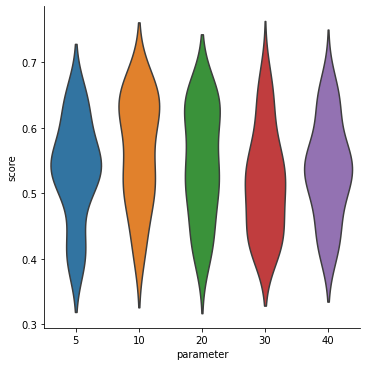

In [90]:
results.plot()

In [91]:
results.mean()

5     0.534962
10    0.565518
20    0.546289
30    0.516846
40    0.535406
dtype: float64

In [92]:
results.annova()

(1.5036178307935868, 0.2041741244743637)

In [93]:
results.scheffe()

,5,10,20,30,40
5,1.000000,0.698338,0.989501,0.941307,1.000000
10,0.698338,1.000000,0.927875,0.237274,0.709893
20,0.989501,0.927875,1.000000,0.727050,0.990981
30,0.941307,0.237274,0.727050,1.000000,0.936159
40,1.000000,0.709893,0.990981,0.936159,1.000000


### Epsilon and Min samples

In [96]:
import itertools
results = Analysis({f'{eps}_{mins}':[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce('umap', n_components=10, random_state=i) \
                    .cluster('dbscan', eps=eps, min_samples=mins) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for eps, mins in itertools.product([0.25,0.5,0.75], [4,5,6])
})

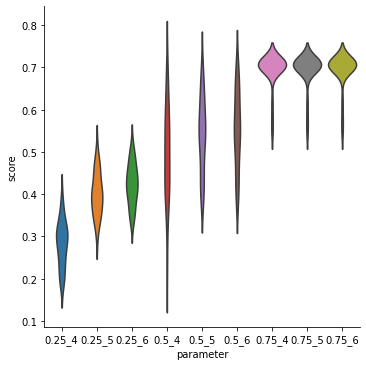

In [97]:
results.plot()

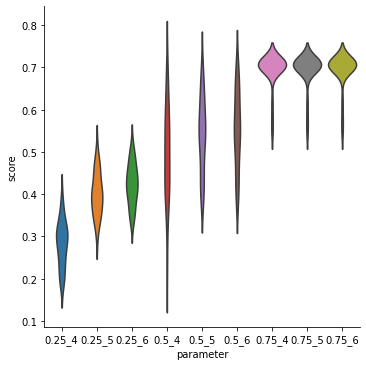

In [98]:
results.plot()

In [99]:
results.mean()

0.25_4    0.283622
0.25_5    0.401493
0.25_6    0.423787
0.5_4     0.497587
0.5_5     0.541338
0.5_6     0.552563
0.75_4    0.694749
0.75_5    0.694749
0.75_6    0.694749
dtype: float64

In [100]:
results.annova()

(142.76917341672402, 9.930240295068326e-91)

In [101]:
results.scheffe()

,0.25_4,0.25_5,0.25_6,0.5_4,0.5_5,0.5_6,0.75_4,0.75_5,0.75_6
0.25_4,1.000000e+00,8.585539e-07,7.301779e-10,1.757278e-22,6.495036e-31,4.010745e-33,9.349342e-61,9.349342e-61,9.349342e-61
0.25_5,8.585539e-07,1.000000e+00,9.895582e-01,2.714803e-04,8.140958e-10,1.603683e-11,6.231551e-38,6.231551e-38,6.231551e-38
0.25_6,7.301779e-10,9.895582e-01,1.000000e+00,2.338652e-02,9.426463e-07,3.088981e-08,1.601365e-33,1.601365e-33,1.601365e-33
0.5_4,1.757278e-22,2.714803e-04,2.338652e-02,1.000000e+00,6.063142e-01,2.662490e-01,2.253654e-19,2.253654e-19,2.253654e-19
0.5_5,6.495036e-31,8.140958e-10,9.426463e-07,6.063142e-01,1.000000e+00,9.999290e-01,6.877046e-12,6.877046e-12,6.877046e-12
0.5_6,4.010745e-33,1.603683e-11,3.088981e-08,2.662490e-01,9.999290e-01,1.000000e+00,3.658021e-10,3.658021e-10,3.658021e-10
0.75_4,9.349342e-61,6.231551e-38,1.601365e-33,2.253654e-19,6.877046e-12,3.658021e-10,1.000000e+00,1.000000e+00,1.000000e+00
0.75_5,9.349342e-61,6.231551e-38,1.601365e-33,2.253654e-19,6.877046e-12,3.658021e-10,1.000000e+00,1.000000e+00,1.000000e+00
0.75_6,9.349342e-61,6.231551e-38,1.601365e-33,2.253654e-19,6.877046e-12,3.658021e-10,1.000000e+00,1.000000e+00,1.000000e+00


### Epsilon

In [102]:
import itertools
results = Analysis({f'{eps}':[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce('umap', n_components=10, random_state=i) \
                    .cluster('dbscan', eps=eps, min_samples=5) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for eps in [0.25,0.5, 0.75, 0.9] \
})

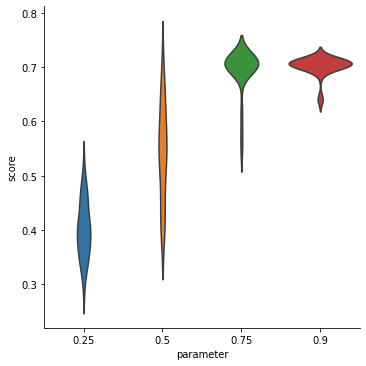

In [103]:
results.plot()

In [104]:
results.mean()

0.25    0.401493
0.5     0.541338
0.75    0.694749
0.9     0.701794
dtype: float64

In [105]:
results.annova()

(200.4181169534129, 1.0206576968640793e-45)

In [106]:
results.scheffe()

,0.25,0.5,0.75,0.9
0.25,1.000000e+00,3.845393e-15,1.734341e-38,1.988030e-39
0.5,3.845393e-15,1.000000e+00,2.432823e-17,1.743874e-18
0.75,1.734341e-38,2.432823e-17,1.000000e+00,9.701337e-01
0.9,1.988030e-39,1.743874e-18,9.701337e-01,1.000000e+00


### Min Samples

In [117]:
import itertools
results = Analysis({f'{m}':[ \
                data.normalize('std') \
                    .remove_outlires('lof') \
                    .reduce('umap', n_components=10, random_state=i) \
                    .cluster('dbscan', eps=0.9, min_samples=m) \
                    .score('silhouette').mean()\
                   for i in range(30)] \
                for m in [4,5,6,7,11] \
})

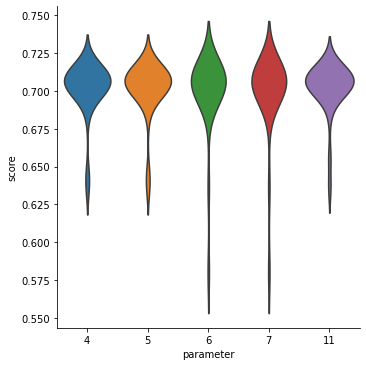

In [118]:
results.plot()

In [119]:
results.mean()

4     0.701794
5     0.701794
6     0.699634
7     0.699634
11    0.702171
dtype: float64

In [120]:
results.annova()

(0.10047880863525278, 0.9821384368972057)

In [121]:
results.scheffe()

,4,5,6,7,11
4,1.000000,1.000000,0.997384,0.997384,0.999997
5,1.000000,1.000000,0.997384,0.997384,0.999997
6,0.997384,0.997384,1.000000,1.000000,0.995116
7,0.997384,0.997384,1.000000,1.000000,0.995116
11,0.999997,0.999997,0.995116,0.995116,1.000000


### Cluster visualisation 

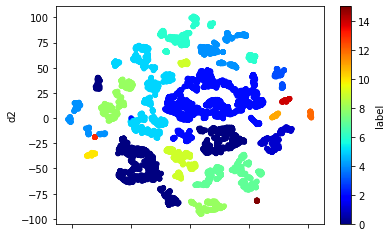

In [122]:
data.normalize('std') \
    .remove_outlires('lof') \
    .reduce('umap', n_components=10) \
    .cluster('dbscan', eps=0.75, min_samples=5) \
    .visualize('tsne')

### corelationg with target class

In [123]:
data.normalize('std') \
    .reduce('umap', n_components=10) \
    .cluster('dbscan', eps=0.75, min_samples=5) \
    .score('v', label='gender')

0.0008111808220679234

In [124]:
data.normalize('std') \
    .reduce('umap', n_components=10) \
    .cluster('dbscan', eps=0.75, min_samples=5) \
    .score('v', label='race')

0.006366142713257149

## Cross methods

In [130]:
results = Analysis({
   'dbscan':[data.normalize('std') \
                  .remove_outlires('lof') \
                  .reduce('umap', n_components=10, random_state=i) \
                  .cluster('dbscan', eps=0.75, min_samples=5) \
                  .score('silhouette').mean() for i in range(30)], \
    'prim': [data.normalize('std') \
                 .remove_outlires('lof') \
                 .reduce('umap', n_components=40, random_state=i) \
                 .cluster('prim', cutoff_scale=0.8) \
                 .score('silhouette').mean() for i in range(30)], \
    'louvain': [data.normalize('std') \
                 .remove_outlires('lof') \
                 .reduce('umap', n_components=15, random_state=i) \
                 .cluster('louvain', modularity='newman') \
                 .score('silhouette').mean() for i in range(30)], \
    'gmm': [data.normalize('std') \
                 .reduce('umap', n_components=5, random_state=i) \
                 .cluster('gmm', n_components=7) \
                 .score('silhouette').mean() for i in range(30)], \
    'kmeans': [data.normalize('std') \
                 .reduce('umap', n_components=5, random_state=i) \
                 .cluster('kmeans', n_clusters=7) \
                 .score('silhouette').mean() for i in range(30)], \
               
})

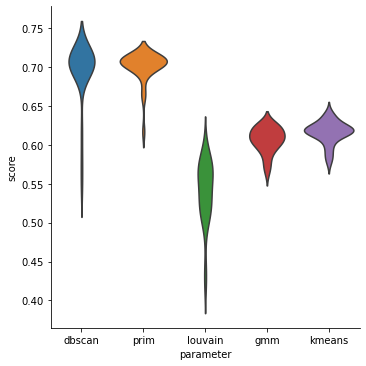

In [131]:
results.plot()

In [132]:
results.mean()

dbscan     0.694749
prim       0.700751
louvain    0.540183
gmm        0.606423
kmeans     0.616089
dtype: float64

In [133]:
results.annova()

(168.36466452909272, 1.9488923621620401e-53)

In [134]:
results.scheffe()

,dbscan,prim,louvain,gmm,kmeans
dbscan,1.000000e+00,9.541465e-01,2.867368e-43,4.430884e-21,1.108831e-17
prim,9.541465e-01,1.000000e+00,4.337429e-45,3.378086e-23,8.676799e-20
louvain,2.867368e-43,4.337429e-45,1.000000e+00,2.048141e-13,1.010447e-16
gmm,4.430884e-21,3.378086e-23,2.048141e-13,1.000000e+00,7.817565e-01
kmeans,1.108831e-17,8.676799e-20,1.010447e-16,7.817565e-01,1.000000e+00
